In [1]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-z2lgifa4
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-z2lgifa4
     |████████████████████████████████| 53 kB 1.0 MB/s 
  Created wheel for glide-text2im: filename=glide_text2im-0.0.0-py3-none-any.whl size=1953663 sha256=66828609a0a165c67d1e428e450755fb07c11a04cf7416f5a635b670d3fd8e73
  Stored in directory: /tmp/pip-ephem-wheel-cache-i30he7vt/wheels/b4/36/07/46711fd6462da277046c6720504e61546b6e32adc0293abc96
Successfully built glide-text2im


In [2]:
from typing import Tuple

from IPython.display import display
from PIL import Image
import numpy as np
import torch as th
import torch.nn.functional as F

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [4]:
# Create base model.
options = model_and_diffusion_defaults()
options['inpaint'] = True
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base-inpaint', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385037638


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['inpaint'] = True
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample-inpaint', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398368198


In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

def read_image(path: str, size: int = 256) -> Tuple[th.Tensor, th.Tensor]:
    pil_img = Image.open(path).convert('RGB')
    pil_img = pil_img.resize((size, size), resample=Image.BICUBIC)
    img = np.array(pil_img)
    return th.from_numpy(img)[None].permute(0, 3, 1, 2).float() / 127.5 - 1

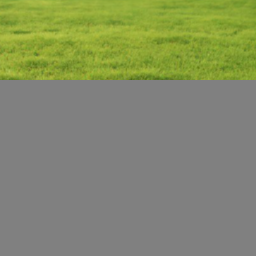

In [9]:
# Sampling parameters
#prompt = "a corgi in a field"

batch_size = 1
guidance_scale = 5.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

# Source image we are inpainting
source_image_256 = read_image('grass.png', size=256)
source_image_64 = read_image('grass.png', size=64)

# The mask should always be a boolean 64x64 mask, and then we
# can upsample it for the second stage.
source_mask_64 = th.ones_like(source_image_64)[:, :1]
source_mask_64[:, :, 20:] = 0
source_mask_256 = F.interpolate(source_mask_64, (256, 256), mode='nearest')

# Visualize the image we are inpainting
show_images(source_image_256 * source_mask_256)

In [10]:
import librosa
import cv2
import numpy as np
import torch
!pip install timm
import timm


/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 16.9 MB/s 


In [11]:
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
#!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!pip install einops ninja

import sys
sys.path.append('./CLIP')
#sys.path.append('./stylegan3')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:33tcmalloc: large alloc 1147494400 bytes == 0x3a3a2000 @  0x7f2f6a0b2615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1055.7 MB 1.7 MB/s eta 0:09:55tcmalloc: large alloc 1434370048 bytes == 0x7e9f8000 @  0x7f2f6a0b2615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

Cloning into 'CLIP'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 225 (delta 0), reused 1 (delta 0), pack-reused 222
Receiving objects: 100% (225/225), 8.91 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CLIP
  Running setup.py develop for clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 20.4 MB/s 


In [12]:
import clip
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import torchvision.transforms as transforms
from collections import OrderedDict

In [13]:
class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])
class AudioEncoder(torch.nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        self.conv = torch.nn.Conv2d(1, 3, (3, 3))
        self.feature_extractor = timm.create_model("resnet18", num_classes=512, pretrained=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.feature_extractor(x)
        return x
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [26]:
clip_model = CLIP()
audio_encoder = AudioEncoder()
audio_encoder.load_state_dict(copyStateDict(torch.load("/content/resnet18_57.pth", map_location=device)))
audio_encoder = audio_encoder.to(device)
audio_encoder.eval()


n_mels = 128
time_length = 864
resize_resolution = 512


y, sr = librosa.load("/content/mixkit-wolf-creature-howling-roar-1777.wav", sr=44100)
audio_inputs = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
audio_inputs = librosa.power_to_db(audio_inputs, ref=np.max) / 80.0 + 1

zero = np.zeros((n_mels, time_length))
h, w = audio_inputs.shape
if w >= time_length:
    j = (w - time_length) // 2
    audio_inputs = audio_inputs[:,j:j+time_length]
else:
    j = (time_length - w) // 2
    zero[:,:w] = audio_inputs[:,:w]
    audio_inputs = zero
    
audio_inputs = cv2.resize(audio_inputs, (n_mels, resize_resolution))
audio_inputs = np.array([audio_inputs])
audio_inputs = torch.from_numpy(audio_inputs.reshape((1, 1, n_mels, resize_resolution))).float().to(device)
with torch.no_grad():
    audio_embedding = audio_encoder(audio_inputs)
    audio_embedding = audio_embedding / audio_embedding.norm(dim=-1, keepdim=True)

  0%|          | 0/100 [00:00<?, ?it/s]

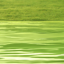

In [28]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
#tokens = model.tokenizer.encode(prompt)
tokens = audio_embedding[0][:128]
tokens = tokens.tolist()
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image
    inpaint_image=(source_image_64 * source_mask_64).repeat(full_batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_64.repeat(full_batch_size, 1, 1, 1).to(device),
)

# Create an classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

In [ ]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),

    # Masked inpainting image.
    inpaint_image=(source_image_256 * source_mask_256).repeat(batch_size, 1, 1, 1).to(device),
    inpaint_mask=source_mask_256.repeat(batch_size, 1, 1, 1).to(device),
)

def denoised_fn(x_start):
    # Force the model to have the exact right x_start predictions
    # for the part of the image which is known.
    return (
        x_start * (1 - model_kwargs['inpaint_mask'])
        + model_kwargs['inpaint_image'] * model_kwargs['inpaint_mask']
    )

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.p_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
    denoised_fn=denoised_fn,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)